# Model-free Reinforcement Learning with policy gradients


# Contributing group members

In [1]:
# import all neccesary modules
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import gym
import numpy as np
from itertools import count
%matplotlib inline  
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.autograd import Variable

eps = np.finfo(np.float32).eps.item()

In [12]:
# taking a look at the environment
gamma = 0.99 #discount factor
render = False #render the environment
log_interval = 10

env = gym.make('CartPole-v1')

for i_episode in range(10):
    state, ep_reward = env.reset(), 0
    for t in range(1, 10000):  # Don't infinite loop while learning
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        if render:
            env.render()
        if done:
            break
env.close()            

# Geting familiar with the environment

Describing the action and state space. (discrete or continuous, how many actions (states) are available, what do the actions (states) describe?)

State space:

Action space:

# Defining the policy

In [3]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()        

        ################################################################################

        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        # Define 2 FC layers
        self.l1 = nn.Linear(self.state_space, 128, bias=False)
        self.l2 = nn.Linear(128, self.action_space, bias=False)
        
        # Discount factor
        self.gamma = gamma
        
        # Episode policy and reward history 
        self.policy_history = torch.Tensor()
        self.reward_episode = []
        
        # Init 2 lists: log probs and rewards
        self.reward_history = []
        self.loss_history = []

        ################################################################################


    def forward(self, x):        

        ################################################################################
        
        model = nn.Sequential(self.l1, nn.Dropout(p=0.6), nn.ReLU(),
                              self.l2, nn.Softmax(dim=-1))
        return model(x)
    
        ################################################################################


Furthermore, initialize an instance of the neural network policy. To update the weights, use an Adam optimizer (torch.optim) with a learning rate of lr=1e-2. 

# Initialization of the policy and the optimizer

In [13]:

    ################################################################################
    
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=0.01)

    ################################################################################



# Sampling an action from the probability distribution over actions of the policy

Now, we need to sample an action from the probability distribution computed by the policy. First, convert the state to a torch tensor. Then, compute the action probabilities and define a categorical distribution over the action probabilities. Last, sample an action from this probability and save the log probability of this action in the corresponding list of the policy.  

In [5]:

def sample_action(state):
    ################################################################################

    
    # Converting State to torch tensor
    state = torch.from_numpy(state).type(torch.FloatTensor)
    
    # Action probabilities & Categorical Distribution
    action_prob = policy(Variable(state))
    prob = Categorical(action_prob)
    
    # Sampling action from a categorical pdf
    action = prob.sample()
        
    # Saving on history
    policy.policy_history = torch.cat([policy.policy_history,
                                       prob.log_prob(action).reshape(1)])

    ################################################################################

    return action.item()

# Estimating the exptected returns 

In the following, you need to compute the estimated return for each state-action pair with respect to the corresponding trajectory. In order to compute the estimate of the expectation over the remaining discounted rewards it is quite reasonable to iterate backwards through the reward list stored in the policy. 

In [6]:
# Define a running variable for the current rewards and a list to store the expected return for each state.
# Iterate backwards through all rewards stored in the corresponding list of the policy and compute the discounted 
# expected return for all remaining states of the current trajectory. (gamma is already defined)
# Note, when iterating backwards, appending the expected return is not a smart move!!!
def estimate_return():
    ################################################################################

    R = 0
    returns = []
    
    # Calculating returns for each episode
    for ret in policy.reward_episode[::-1]:
        R = ret + policy.gamma * R
        returns.insert(0,R)
        
    # Normalizing returns
    returns = torch.FloatTensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    
    ################################################################################

    return returns
    

# Computing the loss and update the weights

Using the estimates for the exptected discounted, you need to update the weights of the policy. Remember that the only difference between the gradient in supervised learning and the gradient of the RL objective in policy gradient is the weighting factor based on the expected return (see the slides of the lecture). To compute the loss of a trajectory, sum over the negative log-likelihood of the chosen action multiplied by the expected return of the current state for all states of the trajectory. Then, use the backwards-function to compute the gradient and update the weights using the optimizer.   

In [7]:
# Define a list for the losses of each state in a trajectory
# Compute the individual loss for each state based on the negative log likelihood of the action and the expected
# return of the current state (you have to iterate over the complete trajectory)
# Prepare the optimizer for an update step
# Compute the overall loss of the policy (sum)
# Compute the gradient
# Update the weights of the network
# Don't forget to delete the stored rewards and the action probs in the corresponding lists of the policy
def update_weights(returns):
    ################################################################################

    
    # Compute loss
    loss = (torch.sum(torch.mul(policy.policy_history, returns).mul(-1), -1))
    
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Save policy history and episode rewards
    policy.loss_history.append(loss.item())
    policy.reward_history.append(np.sum(policy.reward_episode))
    
    # Clear list for the next episode
    policy.policy_history = torch.Tensor([])
    policy.reward_episode= []
    
    ################################################################################



# Putting it all together

The last step is to combine everything. Update the policy with 1000 trajectory samples. The openai gym environments return a terminal flag which you can use to notice a terminal state. Remember policy gradient is on-policy meaning that it is necessary to generate new samples after every single update step. Visualize the evolution of the rewards over time in a plot. Use an exponential weighted moving average over the rewards to get a smooth graph (delta = 0.05). Additionaly, illustrate the cumulative reward of every trajectory in the same plot. Print out after every ten trajectories the trajectory counter, the averaged reward and the last reward.

In [8]:
# Generate 1000 trajectories with a maximum length of 10000. 
running_reward = 10
render = False

    ################################################################################

episodes = 1000
policy.weighted_reward = []

for episode in range(episodes):
    state = env.reset() # Reset environment to generate new samples
    done = False       
    
    for time in range(10000):
        action = sample_action(state)
        
        # Step through environment using chosen action
        state, reward, done, _ = env.step(action)
    
        # Record reward
        policy.reward_episode.append(reward)
        
        # Break the trajectory if terminal flag is returned
        if done:
            break
        
    running_reward = (running_reward * 0.95) + (time * 0.05) 
    policy.weighted_reward.append(running_reward)
    
    # Calculate Returns & Update Weights
    returns = estimate_return()
    update_weights(returns)
    
    if episode % 10 == 0:
        print('Trajectory # {}  \tAverage Reward: {:.2f}\tLast Reward: {:5d}'.format(episode, running_reward, time))
        
    if running_reward > env.spec.reward_threshold:
        print("End of Training. Final Average Reward {}. Last trajectory has {} time steps.".format(running_reward, time))
        break

true_reward = policy.reward_history
averaged_reward = policy.weighted_reward

    ################################################################################



Trajectory # 0  	Average Reward: 10.30	Last Reward:    16
Trajectory # 10  	Average Reward: 15.48	Last Reward:    25
Trajectory # 20  	Average Reward: 22.71	Last Reward:    17
Trajectory # 30  	Average Reward: 34.82	Last Reward:    44
Trajectory # 40  	Average Reward: 53.96	Last Reward:    74
Trajectory # 50  	Average Reward: 72.27	Last Reward:    93
Trajectory # 60  	Average Reward: 126.53	Last Reward:   370
Trajectory # 70  	Average Reward: 140.02	Last Reward:   157
Trajectory # 80  	Average Reward: 172.07	Last Reward:   123
Trajectory # 90  	Average Reward: 170.77	Last Reward:   170
Trajectory # 100  	Average Reward: 203.06	Last Reward:   181
Trajectory # 110  	Average Reward: 298.93	Last Reward:   437
Trajectory # 120  	Average Reward: 372.12	Last Reward:   499
Trajectory # 130  	Average Reward: 421.75	Last Reward:   499
Trajectory # 140  	Average Reward: 388.18	Last Reward:   499
Trajectory # 150  	Average Reward: 369.79	Last Reward:   256
Trajectory # 160  	Average Reward: 312.35

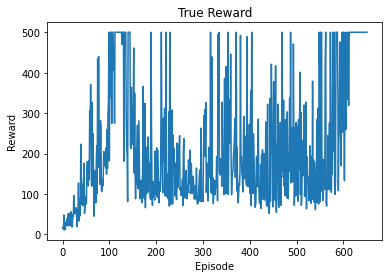

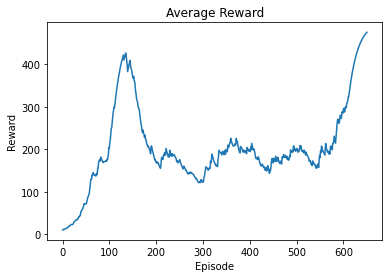

In [9]:
plt.plot(true_reward)
plt.title('True Reward')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

plt.plot(averaged_reward)
plt.title('Average Reward')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

# Rendering the learned policy

In [ ]:
env = gym.make('CartPole-v1')
render = True
for i_episode in range(10):
    state, ep_reward = env.reset(), 0
    for t in range(1, 10000):  # Don't infinite loop while learning
        action = sample_action(state)
        state, reward, done, _ = env.step(action)
        if render:
            env.render()
        if done:
            break
env.close()   